In [10]:
import pandas as pd

In [11]:
label = pd.read_csv('combined_taxonomic_info.csv')
label['genome'] = label['#assembly_accession'].apply(lambda x: x.split('.')[0])
genome2species = {key:item for key, item in zip(label['genome'], label['species'])}
genome2genus = {key:item for key, item in zip(label['genome'], label['genus'])}
genome2family = {key:item for key, item in zip(label['genome'], label['family'])}

In [12]:
p_label = pd.read_csv('virus_taxonomic_info.csv')
p_genome2species = {key:item for key, item in zip(p_label['Accession'], p_label['species'])}
p_genome2genus = {key:item for key, item in zip(p_label['Accession'], p_label['genus'])}
p_genome2family = {key:item for key, item in zip(p_label['Accession'], p_label['family'])}

In [65]:
crispr = pd.read_csv('crispr.csv')
crispr.head()

,qseqid,sseqid,evalue,pident,length,slen,cov
0,NC_092681.1,GCF_002165255_CRISPR_172,0.390,90.909,33,32,1.031250
1,NC_092681.1,GCF_002165255_CRISPR_172,0.390,90.909,33,32,1.031250
2,NC_092681.1,GCA_002165255_CRISPR_172,0.390,90.909,33,32,1.031250
3,NC_092681.1,GCA_002165255_CRISPR_172,0.390,90.909,33,32,1.031250
4,NC_092683.1,GCA_951828385_CRISPR_222,0.002,91.176,34,37,0.918919


In [66]:
crispr['qgenome'] = crispr['qseqid']
crispr['sgenome'] = crispr['sseqid'].apply(lambda x: x.split('_CRISPR_')[0])
crispr['qspecies'] = crispr['qgenome'].apply(lambda x: p_genome2species.get(x), 'unknown')
crispr['sspecies'] = crispr['sgenome'].apply(lambda x: genome2species.get(x), 'unknown')
crispr['qgenus'] = crispr['qgenome'].apply(lambda x: p_genome2genus.get(x, 'unknown'))
crispr['sgenus'] = crispr['sgenome'].apply(lambda x: genome2genus.get(x, 'unknown'))
crispr['qfamily'] = crispr['qgenome'].apply(lambda x: p_genome2family.get(x, 'unknown'))
crispr['sfamily'] = crispr['sgenome'].apply(lambda x: genome2family.get(x, 'unknown'))
crispr = crispr[crispr['sgenus'] != 'unknown']
crispr['cov'] = crispr['length'] / crispr['slen']*100

/var/folders/wx/4pnv2_1n6x7djnlzljyr7b8h0000gn/T/ipykernel_12415/1754979490.py:3: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  crispr['qspecies'] = crispr['qgenome'].apply(lambda x: p_genome2species.get(x), 'unknown')
/var/folders/wx/4pnv2_1n6x7djnlzljyr7b8h0000gn/T/ipykernel_12415/1754979490.py:4: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  crispr['sspecies'] = crispr['sgenome'].apply(lambda x: genome2species.get(x), 'unknown')


In [67]:
crispr = crispr[(crispr['qspecies'] != 'unknown')& (crispr['sspecies'] != 'unknown')& (crispr['qgenus'] != 'unknown') & (crispr['sgenus'] != 'unknown')]
crispr.head()

,qseqid,sseqid,evalue,pident,length,slen,cov,qgenome,sgenome,qspecies,sspecies,qgenus,sgenus,qfamily,sfamily
5,NC_092683.1,GCF_003992745_CRISPR_65,0.1,90.323,31,33,93.939394,NC_092683.1,GCF_003992745,Salmonella enterica,Pectobacterium parmentieri,Salmonella,Pectobacterium,Enterobacteriaceae,Pectobacteriaceae
6,NC_092683.1,GCA_001742145_CRISPR_23,0.1,90.323,31,33,93.939394,NC_092683.1,GCA_001742145,Salmonella enterica,Pectobacterium parmentieri,Salmonella,Pectobacterium,Enterobacteriaceae,Pectobacteriaceae
7,NC_092683.1,GCF_001742145_CRISPR_23,0.1,90.323,31,33,93.939394,NC_092683.1,GCF_001742145,Salmonella enterica,Pectobacterium parmentieri,Salmonella,Pectobacterium,Enterobacteriaceae,Pectobacteriaceae
8,NC_092683.1,GCA_003628575_CRISPR_65,0.1,90.323,31,33,93.939394,NC_092683.1,GCA_003628575,Salmonella enterica,Pectobacterium parmentieri,Salmonella,Pectobacterium,Enterobacteriaceae,Pectobacteriaceae
9,NC_092683.1,GCA_003992745_CRISPR_65,0.1,90.323,31,33,93.939394,NC_092683.1,GCA_003992745,Salmonella enterica,Pectobacterium parmentieri,Salmonella,Pectobacterium,Enterobacteriaceae,Pectobacteriaceae


In [68]:
len(crispr['qseqid'].unique())

3205

In [69]:
# best hit
data = []
data3 = []
for cov in range(90, 101, 1):
    for pident in range(90, 101, 1):
        df_500 = crispr[crispr['cov'] >= cov]
        df_500 = df_500[df_500['pident'] >= pident]
        species_correct = 0
        genus_correct = 0
        family_correct = 0
        for idx, group in df_500.groupby('qseqid'):
            slabel = group['qspecies'].iloc[0]
            glabel = group['qgenus'].iloc[0]
            flabel = group['qfamily'].iloc[0]

            if slabel == group['sspecies'].values[0]:
                species_correct += 1
            
            if glabel == group['sgenus'].values[0]:
                genus_correct += 1
            
            if flabel == group['sfamily'].values[0]:
                family_correct += 1

        data.append([pident, cov, 'species', species_correct/df_500['qseqid'].nunique()])
        data.append([pident, cov, 'genus', genus_correct/df_500['qseqid'].nunique()])
        data.append([pident, cov, 'family', family_correct/df_500['qseqid'].nunique()])
        data3.append([pident, cov, 'species', df_500['qseqid'].nunique()/4698])
        data3.append([pident, cov, 'genus', df_500['qseqid'].nunique()/4698])
        data3.append([pident, cov, 'family', df_500['qseqid'].nunique()/4698])


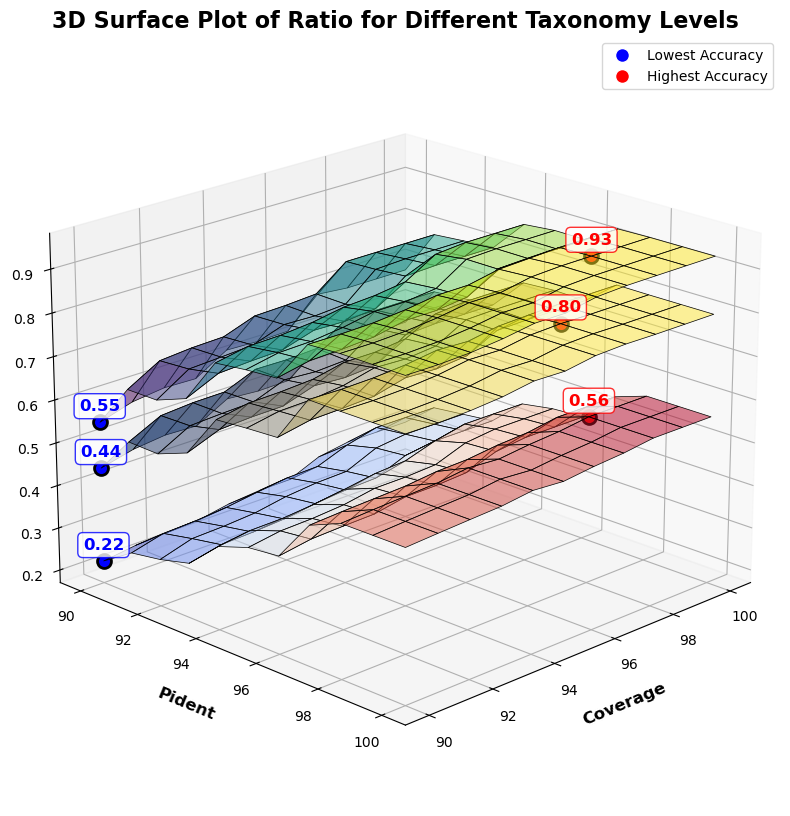

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data, columns=['pident', 'coverage', 'taxonomy', 'accuracy'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['accuracy'].idxmin()]
    max_row = df_level.loc[df_level['accuracy'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='coverage', values='accuracy')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.5, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['coverage'], min_row['pident'], min_row['accuracy'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['coverage'], max_row['pident'], max_row['accuracy'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['coverage'], min_row['pident'], min_row['accuracy'] + 0.02, 
            f"{min_row['accuracy']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['coverage'], max_row['pident'], max_row['accuracy'] + 0.02, 
            f"{max_row['accuracy']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))

# Reverse the Length axis
ax.set_xlim(ax.get_xlim()[::-1])  # Add this line to reverse the Length axis

# Set labels and title for the combined plot
ax.set_xlabel('Coverage', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Ratio', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest Accuracy'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest Accuracy')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('CRISPR_accuracy_best_hit.png', dpi=300, bbox_inches='tight')
plt.show()
df.to_csv('CRISPR_accuracy_best_hit.csv', index=False)

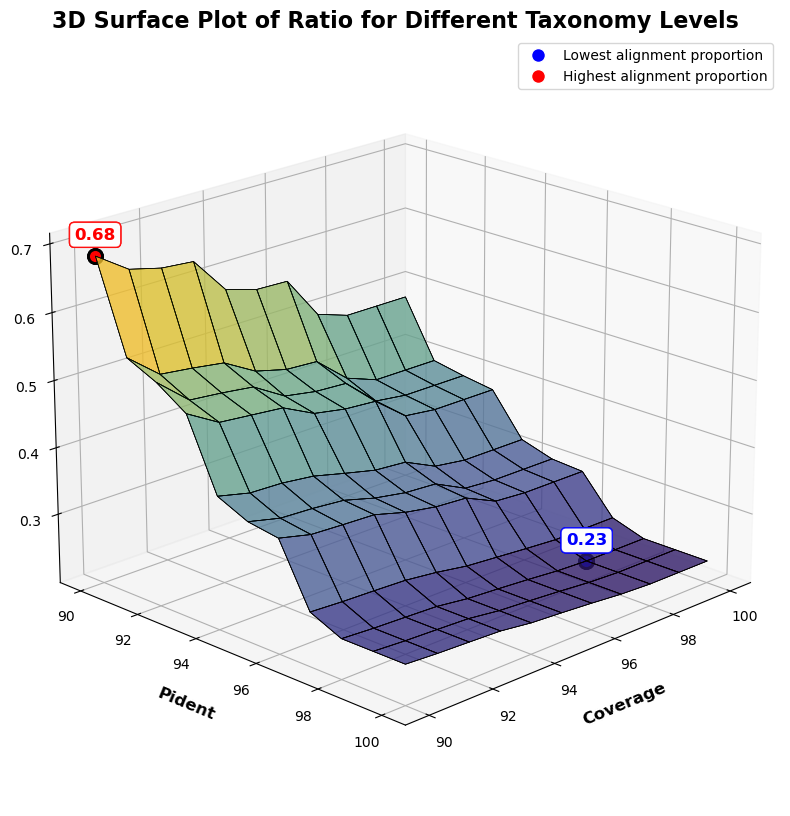

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data3, columns=['pident', 'coverage', 'taxonomy', 'ratio'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['ratio'].idxmin()]
    max_row = df_level.loc[df_level['ratio'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='coverage', values='ratio')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.4, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['coverage'], min_row['pident'], min_row['ratio'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['coverage'], max_row['pident'], max_row['ratio'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['coverage'], min_row['pident'], min_row['ratio'] + 0.02, 
            f"{min_row['ratio']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['coverage'], max_row['pident'], max_row['ratio'] + 0.02, 
            f"{max_row['ratio']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))
# Reverse the Length axis
ax.set_xlim(ax.get_xlim()[::-1])  # Add this line to reverse the Length axis
# Set labels and title for the combined plot
ax.set_xlabel('Coverage', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Ratio', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest alignment proportion'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest alignment proportion')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('CRISPR_alignment_proportion.png', dpi=300, bbox_inches='tight')
plt.show()
df.rename(columns={'ratio': 'alignment_proportion'}, inplace=True)
df.to_csv('CRISPR_alignment_proportion.csv', index=False)

In [72]:
data = []
data2 = []
for cov in range(90, 101, 1):
    for pident in range(90, 101, 1):
        df_500 = crispr[crispr['cov'] >= cov]
        df_500 = df_500[df_500['pident'] >= pident]
        species_correct = 0
        species_pred = 0
        genus_correct = 0
        genus_pred = 0
        family_correct = 0
        family_pred = 0
        for idx, group in df_500.groupby('qseqid'):
            slabel = group['qspecies'].iloc[0]
            glabel = group['qgenus'].iloc[0]
            flabel = group['qfamily'].iloc[0]

            species_pred += len(group['sspecies'].unique())
            if slabel in group['sspecies'].values:
                species_correct += 1
            
            genus_pred += len(group['sgenus'].unique())
            if glabel in group['sgenus'].values:
                genus_correct += 1
            
            family_pred += len(group['sfamily'].unique())
            if flabel in group['sfamily'].values:
                family_correct += 1

        data.append([pident, cov, 'species', species_correct/df_500['qseqid'].nunique()])
        data.append([pident, cov, 'genus', genus_correct/df_500['qseqid'].nunique()])
        data.append([pident, cov, 'family', family_correct/df_500['qseqid'].nunique()])
        data2.append([pident, cov, 'species', species_correct/species_pred])
        data2.append([pident, cov, 'genus', genus_correct/genus_pred])
        data2.append([pident, cov, 'family', family_correct/family_pred])
        #print("Species level: ", species_correct, species_pred, species_correct/species_pred, species_correct/df_500['qseqid'].nunique())
        #print("Genus level: ", genus_correct, genus_pred, genus_correct/genus_pred, genus_correct/df_500['qseqid'].nunique())
        #print("Family level: ", family_correct, family_pred, family_correct/family_pred, family_correct/df_500['qseqid'].nunique())
        #print("Prediction rate: ", df_500['qseqid'].nunique()/19974)

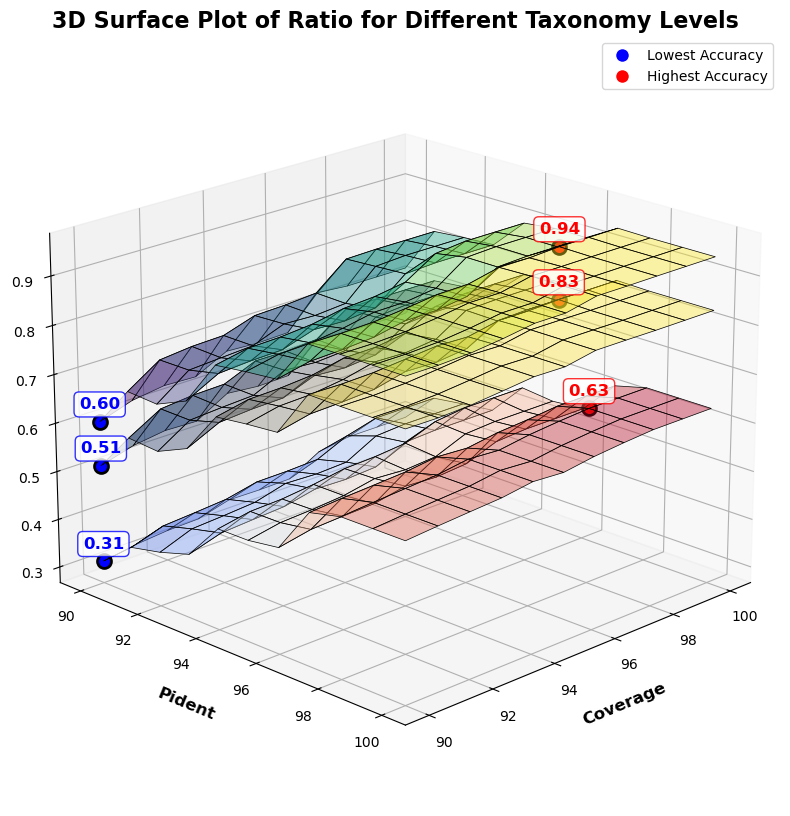

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data, columns=['pident', 'coverage', 'taxonomy', 'accuracy'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['accuracy'].idxmin()]
    max_row = df_level.loc[df_level['accuracy'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='coverage', values='accuracy')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.4, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['coverage'], min_row['pident'], min_row['accuracy'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['coverage'], max_row['pident'], max_row['accuracy'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['coverage'], min_row['pident'], min_row['accuracy'] + 0.02, 
            f"{min_row['accuracy']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['coverage'], max_row['pident'], max_row['accuracy'] + 0.02, 
            f"{max_row['accuracy']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))

# Reverse the Length axis
ax.set_xlim(ax.get_xlim()[::-1])  # Add this line to reverse the Length axis
# Set labels and title for the combined plot
ax.set_xlabel('Coverage', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Ratio', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest Accuracy'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest Accuracy')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('CRISPR_accuracy_all.png', dpi=300, bbox_inches='tight')
plt.show()
df.to_csv('CRISPR_accuracy_all.csv', index=False)

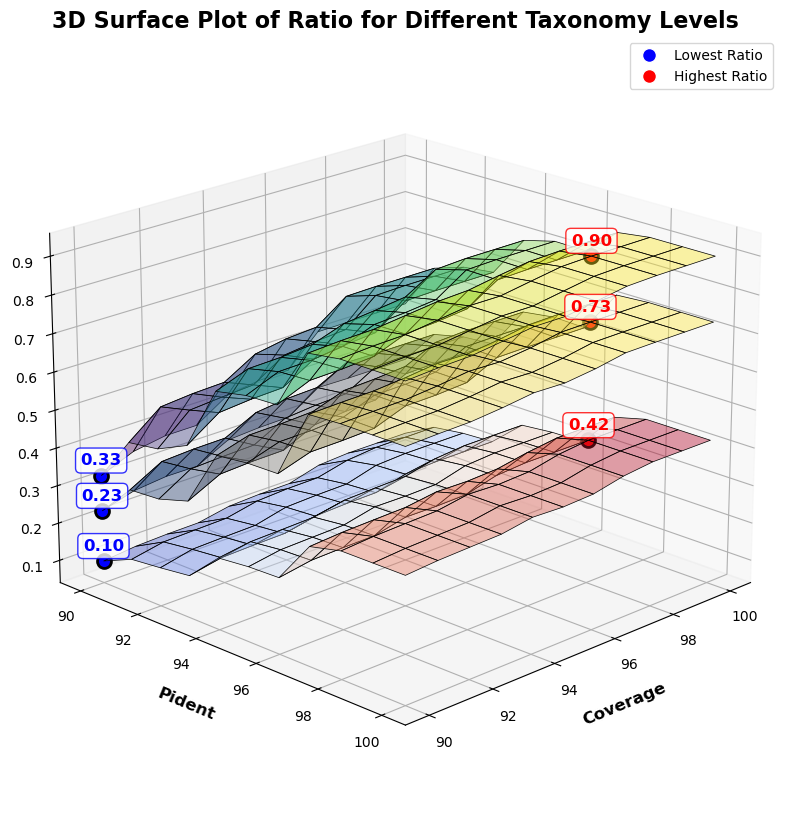

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data2, columns=['pident', 'coverage', 'taxonomy', 'ratio'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['ratio'].idxmin()]
    max_row = df_level.loc[df_level['ratio'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='coverage', values='ratio')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.4, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['coverage'], min_row['pident'], min_row['ratio'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['coverage'], max_row['pident'], max_row['ratio'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['coverage'], min_row['pident'], min_row['ratio'] + 0.02, 
            f"{min_row['ratio']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['coverage'], max_row['pident'], max_row['ratio'] + 0.02, 
            f"{max_row['ratio']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))

# Reverse the Length axis
ax.set_xlim(ax.get_xlim()[::-1])  # Add this line to reverse the Length axis

# Set labels and title for the combined plot
ax.set_xlabel('Coverage', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Ratio', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest Ratio'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest Ratio')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('CRISPR_accuracy_ratio.png', dpi=300, bbox_inches='tight')
plt.show()
df.to_csv('CRISPR_accuracy_ratio.csv', index=False)

# tRNA

In [24]:
import pandas as pd
from tqdm import tqdm

In [25]:
tRNA = pd.read_csv('tRNA_results.csv')
tRNA.head()

,0,1,2,3,4,5,cov
0,NC_074749.1,GCA_039908025_52,1.890000e-25,90.323,93,93,1.0
1,NC_074749.1,GCF_019857345_44,1.890000e-25,90.323,93,93,1.0
2,NC_074749.1,GCA_039908075_52,1.890000e-25,90.323,93,93,1.0
3,NC_074749.1,GCF_030121875_1,1.890000e-25,90.323,93,93,1.0
4,NC_074749.1,GCA_039830125_65,1.890000e-25,90.323,93,93,1.0


In [26]:
tRNA['genome'] = tRNA['1'].apply(lambda x: x.rsplit('_', 1)[0])
tRNA['cov'] = tRNA['cov']*100
tRNA.rename(columns={'0': 'qseqid', '1': 'sseqid', '2': 'evalue', '3': 'pident'}, inplace=True)

In [27]:
label = pd.read_csv('combined_taxonomic_info.csv')
label['genome'] = label['#assembly_accession'].apply(lambda x: x.split('.')[0])
genome2species = {key:item for key, item in zip(label['genome'], label['species'])}
genome2genus = {key:item for key, item in zip(label['genome'], label['genus'])}
genome2family = {key:item for key, item in zip(label['genome'], label['family'])}

In [28]:
p_label = pd.read_csv('virus_taxonomic_info.csv')
p_genome2species = {key:item for key, item in zip(p_label['Accession'], p_label['species'])}
p_genome2genus = {key:item for key, item in zip(p_label['Accession'], p_label['genus'])}
p_genome2family = {key:item for key, item in zip(p_label['Accession'], p_label['family'])}

In [29]:
tRNA['qspecies'] = tRNA['qseqid'].apply(lambda x: p_genome2species.get(x, 'Unknown'))
tRNA['sspecies'] = tRNA['genome'].apply(lambda x: genome2species.get(x, 'Unknown'))
tRNA['qgenus'] = tRNA['qseqid'].apply(lambda x: p_genome2genus.get(x, 'Unknown'))
tRNA['sgenus'] = tRNA['genome'].apply(lambda x: genome2genus.get(x, 'Unknown'))
tRNA['qfamily'] = tRNA['qseqid'].apply(lambda x: p_genome2family.get(x, 'Unknown'))
tRNA['sfamily'] = tRNA['genome'].apply(lambda x: genome2family.get(x, 'Unknown'))

In [39]:
tRNA = tRNA[(tRNA['qspecies'] != 'Unknown') & (tRNA['sspecies'] != 'Unknown') &
        (tRNA['qgenus'] != 'Unknown') & (tRNA['sgenus'] != 'Unknown') &
        (tRNA['qfamily'] != 'Unknown') & (tRNA['sfamily'] != 'Unknown')]

In [40]:
# best hit
data = []
data2 = []
data3 = []
for cov in range(90, 101, 1):
    for pident in range(90, 101, 1):
        df_500 = tRNA[tRNA['cov'] >= cov]
        df_500 = df_500[df_500['pident'] >= pident]
        species_correct = 0
        genus_correct = 0
        family_correct = 0
        for idx, group in df_500.groupby('qseqid'):
            slabel = group['qspecies'].iloc[0]
            glabel = group['qgenus'].iloc[0]
            flabel = group['qfamily'].iloc[0]

            if slabel == group['sspecies'].values[0]:
                species_correct += 1
            
            if glabel == group['sgenus'].values[0]:
                genus_correct += 1
            
            if flabel == group['sfamily'].values[0]:
                family_correct += 1

        data.append([pident, cov, 'species', species_correct/df_500['qseqid'].nunique()])
        data.append([pident, cov, 'genus', genus_correct/df_500['qseqid'].nunique()])
        data.append([pident, cov, 'family', family_correct/df_500['qseqid'].nunique()])
        data3.append([pident, cov, 'species', df_500['qseqid'].nunique()/4698])
        data3.append([pident, cov, 'genus', df_500['qseqid'].nunique()/4698])
        data3.append([pident, cov, 'family', df_500['qseqid'].nunique()/4698])


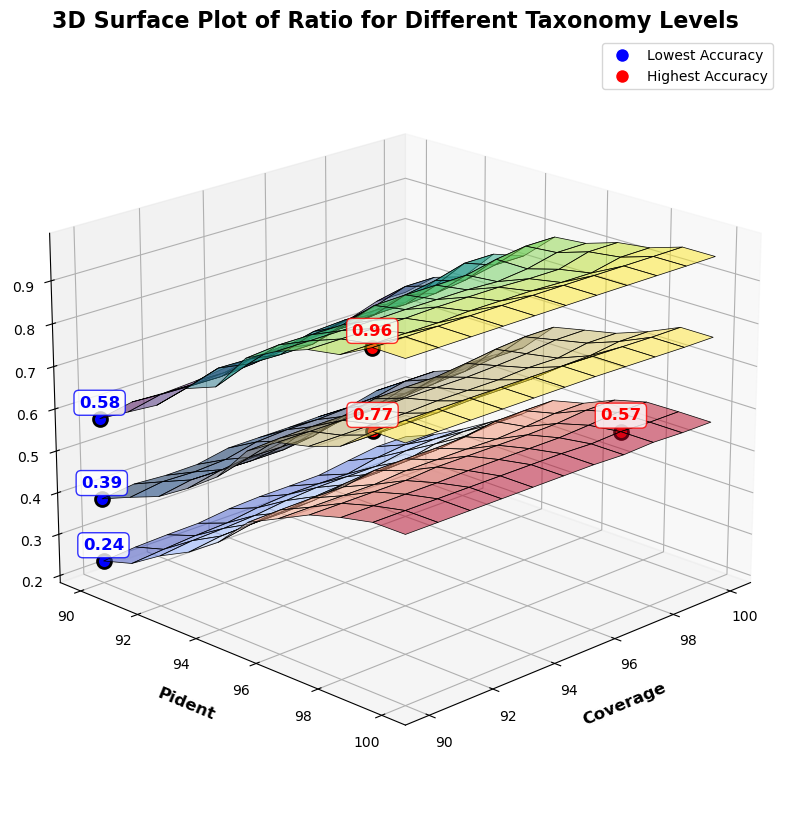

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data, columns=['pident', 'coverage', 'taxonomy', 'accuracy'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['accuracy'].idxmin()]
    max_row = df_level.loc[df_level['accuracy'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='coverage', values='accuracy')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.5, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['coverage'], min_row['pident'], min_row['accuracy'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['coverage'], max_row['pident'], max_row['accuracy'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['coverage'], min_row['pident'], min_row['accuracy'] + 0.02, 
            f"{min_row['accuracy']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['coverage'], max_row['pident'], max_row['accuracy'] + 0.02, 
            f"{max_row['accuracy']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))

# Reverse the Length axis
ax.set_xlim(ax.get_xlim()[::-1])  # Add this line to reverse the Length axis

# Set labels and title for the combined plot
ax.set_xlabel('Coverage', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Ratio', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest Accuracy'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest Accuracy')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('tRNA_accuracy_best_hit.png', dpi=300, bbox_inches='tight')
plt.show()
df.to_csv('tRNA_accuracy_best_hit.csv', index=False)

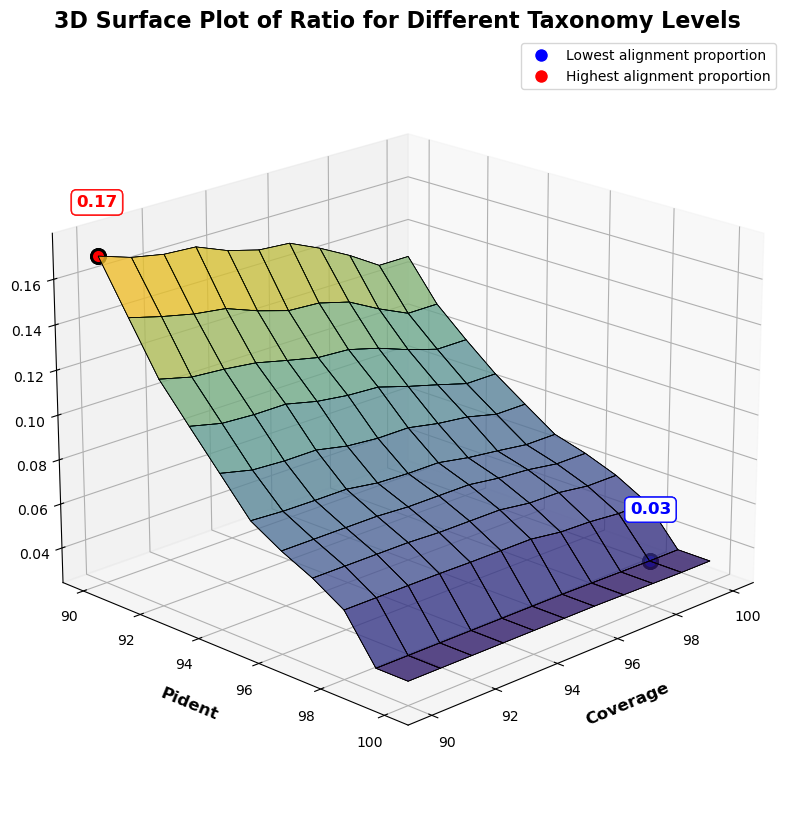

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data3, columns=['pident', 'coverage', 'taxonomy', 'ratio'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['ratio'].idxmin()]
    max_row = df_level.loc[df_level['ratio'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='coverage', values='ratio')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.4, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['coverage'], min_row['pident'], min_row['ratio'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['coverage'], max_row['pident'], max_row['ratio'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['coverage'], min_row['pident'], min_row['ratio'] + 0.02, 
            f"{min_row['ratio']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['coverage'], max_row['pident'], max_row['ratio'] + 0.02, 
            f"{max_row['ratio']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))
# Reverse the Length axis
ax.set_xlim(ax.get_xlim()[::-1])  # Add this line to reverse the Length axis
# Set labels and title for the combined plot
ax.set_xlabel('Coverage', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Ratio', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest alignment proportion'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest alignment proportion')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('tRNA_alignment_proportion.png', dpi=300, bbox_inches='tight')
plt.show()
df.rename(columns={'ratio': 'alignment_proportion'}, inplace=True)
df.to_csv('tRNA_alignment_proportion.csv', index=False)

In [43]:
data = []
data2 = []
for cov in range(90, 101, 1):
    for pident in range(90, 101, 1):
        df_500 = tRNA[tRNA['cov'] >= cov]
        df_500 = df_500[df_500['pident'] >= pident]
        species_correct = 0
        species_pred = 0
        genus_correct = 0
        genus_pred = 0
        family_correct = 0
        family_pred = 0
        for idx, group in df_500.groupby('qseqid'):
            slabel = group['qspecies'].iloc[0]
            glabel = group['qgenus'].iloc[0]
            flabel = group['qfamily'].iloc[0]

            species_pred += len(group['sspecies'].unique())
            if slabel in group['sspecies'].values:
                species_correct += 1
            
            genus_pred += len(group['sgenus'].unique())
            if glabel in group['sgenus'].values:
                genus_correct += 1
            
            family_pred += len(group['sfamily'].unique())
            if flabel in group['sfamily'].values:
                family_correct += 1

        data.append([pident, cov, 'species', species_correct/df_500['qseqid'].nunique()])
        data.append([pident, cov, 'genus', genus_correct/df_500['qseqid'].nunique()])
        data.append([pident, cov, 'family', family_correct/df_500['qseqid'].nunique()])
        data2.append([pident, cov, 'species', species_correct/species_pred])
        data2.append([pident, cov, 'genus', genus_correct/genus_pred])
        data2.append([pident, cov, 'family', family_correct/family_pred])
        #print("Species level: ", species_correct, species_pred, species_correct/species_pred, species_correct/df_500['qseqid'].nunique())
        #print("Genus level: ", genus_correct, genus_pred, genus_correct/genus_pred, genus_correct/df_500['qseqid'].nunique())
        #print("Family level: ", family_correct, family_pred, family_correct/family_pred, family_correct/df_500['qseqid'].nunique())
        #print("Prediction rate: ", df_500['qseqid'].nunique()/19974)

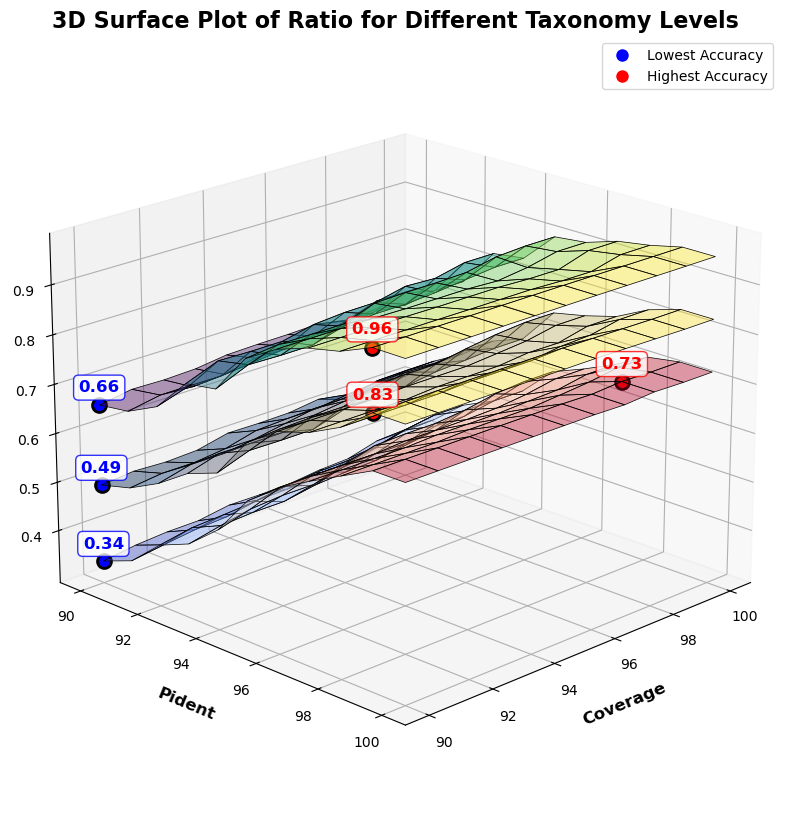

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data, columns=['pident', 'coverage', 'taxonomy', 'accuracy'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['accuracy'].idxmin()]
    max_row = df_level.loc[df_level['accuracy'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='coverage', values='accuracy')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.4, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['coverage'], min_row['pident'], min_row['accuracy'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['coverage'], max_row['pident'], max_row['accuracy'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['coverage'], min_row['pident'], min_row['accuracy'] + 0.02, 
            f"{min_row['accuracy']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['coverage'], max_row['pident'], max_row['accuracy'] + 0.02, 
            f"{max_row['accuracy']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))

# Reverse the Length axis
ax.set_xlim(ax.get_xlim()[::-1])  # Add this line to reverse the Length axis
# Set labels and title for the combined plot
ax.set_xlabel('Coverage', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Ratio', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest Accuracy'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest Accuracy')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('tRNA_accuracy_all.png', dpi=300, bbox_inches='tight')
plt.show()
df.to_csv('tRNA_accuracy_all.csv', index=False)

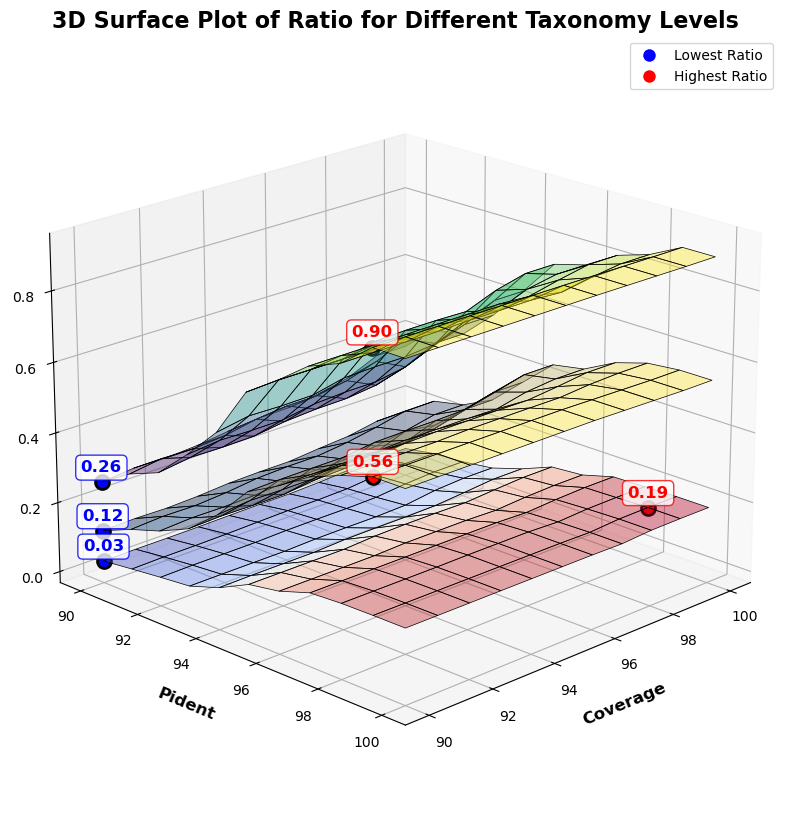

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data2, columns=['pident', 'coverage', 'taxonomy', 'ratio'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['ratio'].idxmin()]
    max_row = df_level.loc[df_level['ratio'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='coverage', values='ratio')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.4, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['coverage'], min_row['pident'], min_row['ratio'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['coverage'], max_row['pident'], max_row['ratio'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['coverage'], min_row['pident'], min_row['ratio'] + 0.02, 
            f"{min_row['ratio']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['coverage'], max_row['pident'], max_row['ratio'] + 0.02, 
            f"{max_row['ratio']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))

# Reverse the Length axis
ax.set_xlim(ax.get_xlim()[::-1])  # Add this line to reverse the Length axis

# Set labels and title for the combined plot
ax.set_xlabel('Coverage', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Ratio', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest Ratio'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest Ratio')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('tRNA_accuracy_ratio.png', dpi=300, bbox_inches='tight')
plt.show()
df.to_csv('tRNA_accuracy_ratio.csv', index=False)

# BLASTN

In [76]:
BLASTN_df = pd.read_csv('BLASTN.csv')
BLASTN_df = BLASTN_df.drop(columns=['sseqid', 'evalue'])
BLASTN_df.head()

,qseqid,pident,length,genome
0,NC_070911.1,94.000,100,GCF_024918215
1,NC_071003.1,90.020,2475,GCF_024918215
2,NC_071003.1,90.357,2437,GCF_024918215
3,NC_071003.1,90.357,2437,GCF_024918215
4,NC_071003.1,91.882,1663,GCF_024918215


In [77]:
BLASTN_df['qspecies'] = BLASTN_df['qseqid'].apply(lambda x: p_genome2species.get(x, 'unknown'))
BLASTN_df['sspecies'] = BLASTN_df['genome'].apply(lambda x: genome2species.get(x, 'unknown'))
BLASTN_df['qgenus'] = BLASTN_df['qseqid'].apply(lambda x: p_genome2genus.get(x, 'unknown'))
BLASTN_df['sgenus'] = BLASTN_df['genome'].apply(lambda x: genome2genus.get(x, 'unknown'))
BLASTN_df['qfamily'] = BLASTN_df['qseqid'].apply(lambda x: p_genome2family.get(x, 'unknown'))
BLASTN_df['sfamily'] = BLASTN_df['genome'].apply(lambda x: genome2family.get(x, 'unknown'))

In [78]:
BLASTN_df = BLASTN_df[(BLASTN_df['qspecies'] != 'unknown') & (BLASTN_df['sspecies'] != 'unknown') &
        (BLASTN_df['qgenus'] != 'unknown') & (BLASTN_df['sgenus'] != 'unknown') &
        (BLASTN_df['qfamily'] != 'unknown') & (BLASTN_df['sfamily'] != 'unknown')]

In [79]:
BLASTN_df.drop_duplicates(subset=['qseqid', 'genome'], inplace=True)

In [80]:
from tqdm import tqdm

In [81]:
data = []
data3 = []
with tqdm(total=100) as pbar:
    for length in range(100, 1050, 100):
        for pident in range(90, 101, 1):
            df_500 = BLASTN_df[BLASTN_df['length'] >= length]
            df_500 = df_500[df_500['pident'] >= pident]
            species_correct = 0
            species_pred = 0
            genus_correct = 0
            genus_pred = 0
            family_correct = 0
            family_pred = 0
            for idx, group in df_500.groupby('qseqid'):
                slabel = group['qspecies'].iloc[0]
                glabel = group['qgenus'].iloc[0]
                flabel = group['qfamily'].iloc[0]

                if slabel == group['sspecies'].values[0]:
                    species_correct += 1
                
                if glabel == group['sgenus'].values[0]:
                    genus_correct += 1
                
                if flabel == group['sfamily'].values[0]:
                    family_correct += 1

            data.append([pident, length, 'species', species_correct/df_500['qseqid'].nunique()])
            data.append([pident, length, 'genus', genus_correct/df_500['qseqid'].nunique()])
            data.append([pident, length, 'family', family_correct/df_500['qseqid'].nunique()])

            data3.append([pident, length, 'species', df_500['qseqid'].nunique()/4698])
            data3.append([pident, length, 'genus', df_500['qseqid'].nunique()/4698])
            data3.append([pident, length, 'family', df_500['qseqid'].nunique()/4698])
            _ = pbar.update(1)
        #data2.append([pident, length, 'species', species_correct/species_pred])
        #data2.append([pident, length, 'genus', genus_correct/genus_pred])
        #data2.append([pident, length, 'family', family_correct/family_pred])
        #print(f"Threshold {length}")
        #print("Species level: ", species_correct, species_pred, species_correct/species_pred, species_correct/df_500['qseqid'].nunique())
        #print("Genus level: ", genus_correct, genus_pred, genus_correct/genus_pred, genus_correct/df_500['qseqid'].nunique())
        #print("Family level: ", family_correct, family_pred, family_correct/family_pred, family_correct/df_500['qseqid'].nunique())
        #print("Prediction rate: ", df_500['qseqid'].nunique()/19974)

110it [01:10,  1.55it/s]                         


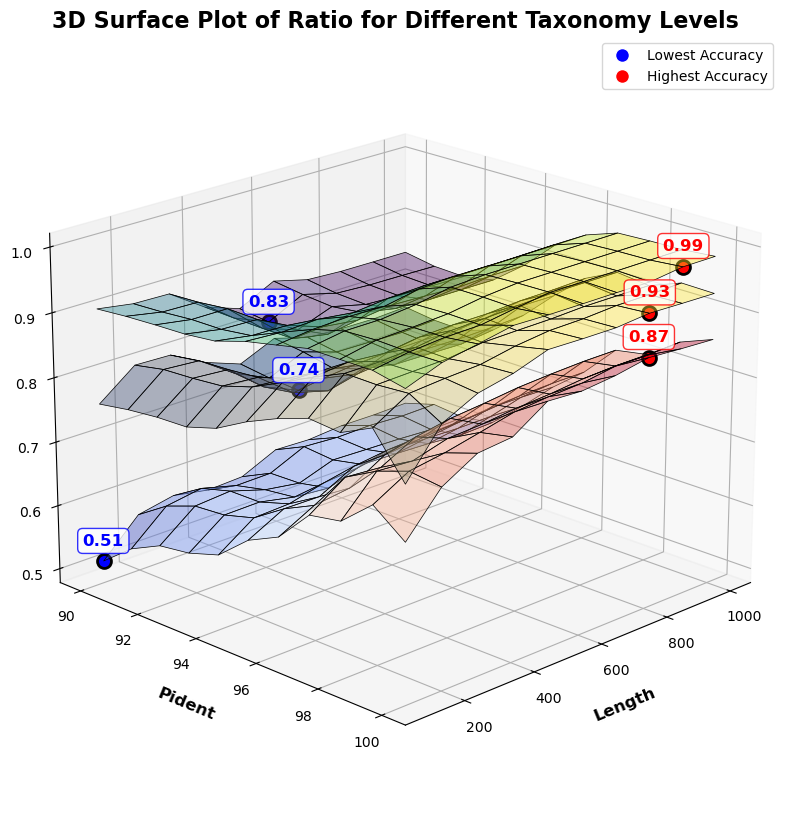

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data, columns=['pident', 'length', 'taxonomy', 'accuracy'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['accuracy'].idxmin()]
    max_row = df_level.loc[df_level['accuracy'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='length', values='accuracy')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.4, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['length'], min_row['pident'], min_row['accuracy'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['length'], max_row['pident'], max_row['accuracy'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['length'], min_row['pident'], min_row['accuracy'] + 0.02, 
            f"{min_row['accuracy']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['length'], max_row['pident'], max_row['accuracy'] + 0.02, 
            f"{max_row['accuracy']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))

# Set labels and title for the combined plot
ax.set_xlabel('Length', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Ratio', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')

# Reverse the length axis
ax.set_xlim(ax.get_xlim()[::-1])

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest Accuracy'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest Accuracy')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('BLASTN_accuracy_best_hit.png', dpi=300, bbox_inches='tight')
plt.show()
df.to_csv('BLASTN_accuracy_best_hit.csv', index=False)

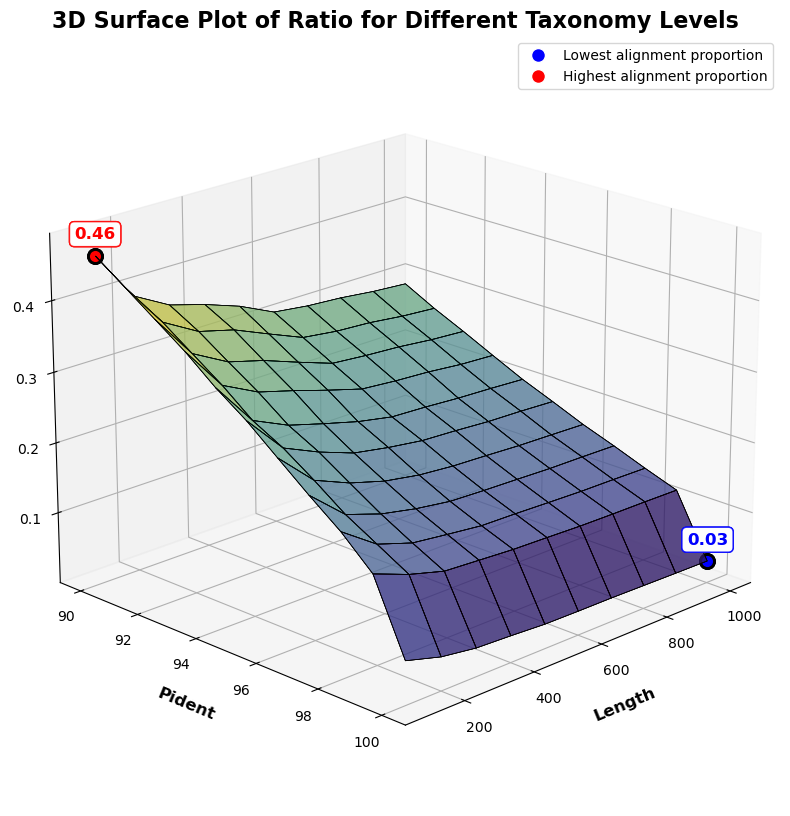

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data3, columns=['pident', 'length', 'taxonomy', 'ratio'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['ratio'].idxmin()]
    max_row = df_level.loc[df_level['ratio'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='length', values='ratio')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.4, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['length'], min_row['pident'], min_row['ratio'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['length'], max_row['pident'], max_row['ratio'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['length'], min_row['pident'], min_row['ratio'] + 0.02, 
            f"{min_row['ratio']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['length'], max_row['pident'], max_row['ratio'] + 0.02, 
            f"{max_row['ratio']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))

# Set labels and title for the combined plot
ax.set_xlabel('Length', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Ratio', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')

# Reverse the length axis
ax.set_xlim(ax.get_xlim()[::-1])

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest alignment proportion'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest alignment proportion')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('BLASTN_alignment_proportion.png', dpi=300, bbox_inches='tight')
plt.show()
df.rename(columns={'ratio': 'alignment_proportion'}, inplace=True)
df.to_csv('BLASTN_alignment_proportion.csv', index=False)

In [85]:
data = []
data2 = []
for length in range(100, 1050, 100):
    for pident in range(90, 101, 1):
        df_500 = BLASTN_df[BLASTN_df['length'] >= length]
        df_500 = df_500[df_500['pident'] >= pident]
        species_correct = 0
        species_pred = 0
        genus_correct = 0
        genus_pred = 0
        family_correct = 0
        family_pred = 0
        for idx, group in df_500.groupby('qseqid'):
            slabel = group['qspecies'].iloc[0]
            glabel = group['qgenus'].iloc[0]
            flabel = group['qfamily'].iloc[0]

            species_pred += len(group['sspecies'].unique())
            if slabel in group['sspecies'].values:
                species_correct += 1
            
            genus_pred += len(group['sgenus'].unique())
            if glabel in group['sgenus'].values:
                genus_correct += 1
            
            family_pred += len(group['sfamily'].unique())
            if flabel in group['sfamily'].values:
                family_correct += 1

        data.append([pident, length, 'species', species_correct/df_500['qseqid'].nunique()])
        data.append([pident, length, 'genus', genus_correct/df_500['qseqid'].nunique()])
        data.append([pident, length, 'family', family_correct/df_500['qseqid'].nunique()])
        data2.append([pident, length, 'species', species_correct/species_pred])
        data2.append([pident, length, 'genus', genus_correct/genus_pred])
        data2.append([pident, length, 'family', family_correct/family_pred])
        #print(f"Threshold {length}")
        #print("Species level: ", species_correct, species_pred, species_correct/species_pred, species_correct/df_500['qseqid'].nunique())
        #print("Genus level: ", genus_correct, genus_pred, genus_correct/genus_pred, genus_correct/df_500['qseqid'].nunique())
        #print("Family level: ", family_correct, family_pred, family_correct/family_pred, family_correct/df_500['qseqid'].nunique())
        #print("Prediction rate: ", df_500['qseqid'].nunique()/19974)

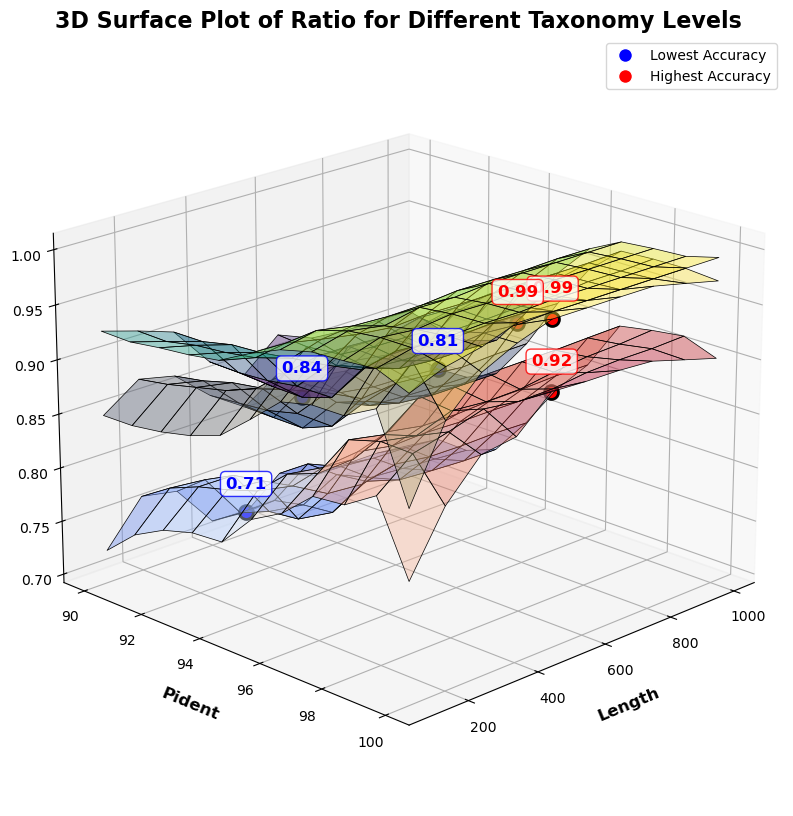

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data, columns=['pident', 'length', 'taxonomy', 'accuracy'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['accuracy'].idxmin()]
    max_row = df_level.loc[df_level['accuracy'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='length', values='accuracy')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.4, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['length'], min_row['pident'], min_row['accuracy'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['length'], max_row['pident'], max_row['accuracy'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['length'], min_row['pident'], min_row['accuracy'] + 0.02, 
            f"{min_row['accuracy']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['length'], max_row['pident'], max_row['accuracy'] + 0.02, 
            f"{max_row['accuracy']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))

# Set labels and title for the combined plot
ax.set_xlabel('Length', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Accuracy', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')


# Reverse the length axis
ax.set_xlim(ax.get_xlim()[::-1])

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest Accuracy'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest Accuracy')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('BLASTN_accuracy_all.png', dpi=300, bbox_inches='tight')
plt.show()
df.to_csv('BLASTN_accuracy_all.csv', index=False)

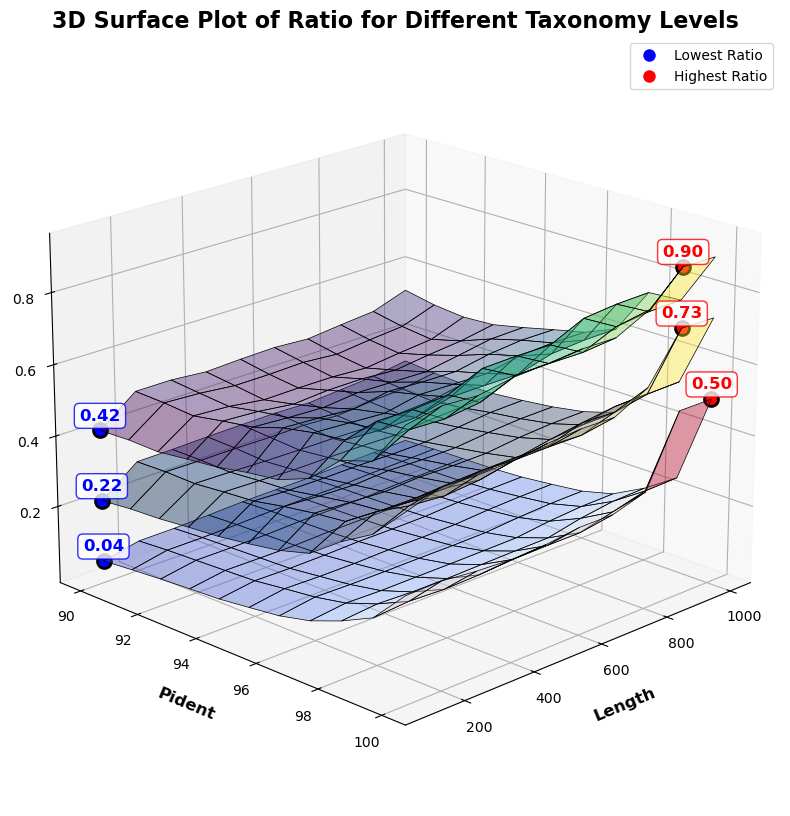

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data2, columns=['pident', 'length', 'taxonomy', 'ratio'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['ratio'].idxmin()]
    max_row = df_level.loc[df_level['ratio'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='length', values='ratio')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.4, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['length'], min_row['pident'], min_row['ratio'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['length'], max_row['pident'], max_row['ratio'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['length'], min_row['pident'], min_row['ratio'] + 0.02, 
            f"{min_row['ratio']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['length'], max_row['pident'], max_row['ratio'] + 0.02, 
            f"{max_row['ratio']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))

# Set labels and title for the combined plot
ax.set_xlabel('Length', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Ratio', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')

# Reverse the length axis
ax.set_xlim(ax.get_xlim()[::-1])

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest Ratio'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest Ratio')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('BLASTN_accuracy_ratio.png', dpi=300, bbox_inches='tight')
plt.show()
df.to_csv('BLASTN_accuracy_ratio.csv', index=False)

# consistency

In [24]:
tRNA.shape

(44778, 14)

In [ ]:
BLASTN_df.shape

(18694095, 10)

In [26]:
crispr.shape

(92885, 15)

In [ ]:
crispr_species = crispr[crispr['cov'] >= 98]
crispr_species = crispr_species[crispr_species['pident'] >= 98]
crispr_species.drop_duplicates(subset=['qseqid'], inplace=True)
crispr_species = crispr_species[crispr_species['qspecies'] == crispr_species['sspecies']]
print("CRISPR", crispr_species.shape)

df_species = BLASTN_df[BLASTN_df['length'] >= 700]
df_species = df_species[df_species['pident'] >= 100]
df_species.drop_duplicates(subset=['qseqid'], inplace=True)
df_species = df_species[df_species['qspecies'] == df_species['sspecies']]
print("BLASTN", df_species.shape)

tRNA_species = tRNA[tRNA['cov'] >= 98]
tRNA_species = tRNA_species[tRNA_species['pident'] >= 98]
tRNA_species.drop_duplicates(subset=['qseqid'], inplace=True)
tRNA_species = tRNA_species[tRNA_species['qspecies'] == tRNA_species['sspecies']]
print("tRNA", tRNA_species.shape)

CRISPR (603, 15)
BLASTN (246, 10)
tRNA (137, 14)


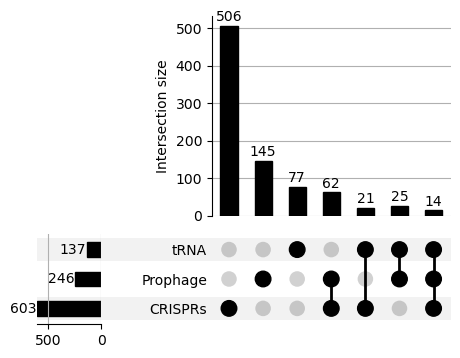

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from upsetplot import from_memberships
from upsetplot import plot


# Prepare data for UpSet plot
example = from_memberships(
    [
        ['CRISPRs'],
        ['Prophage'],
        ['tRNA'],
        ['CRISPRs', 'Prophage'],
        ['tRNA', 'CRISPRs'],
        ['tRNA', 'Prophage'],
        ['tRNA', 'CRISPRs', 'Prophage']
    ],
    data=[
        len(set(crispr_species['qseqid']) - set(df_species['qseqid']) - set(tRNA_species['qseqid'])),
        len(set(df_species['qseqid']) - set(crispr_species['qseqid']) - set(tRNA_species['qseqid'])),
        len(set(tRNA_species['qseqid']) - set(df_species['qseqid']) - set(crispr_species['qseqid'])),
        len(set(crispr_species['qseqid']) & set(df_species['qseqid']) - set(tRNA_species['qseqid'])),
        len(set(tRNA_species['qseqid']) & set(crispr_species['qseqid']) - set(df_species['qseqid'])),
        len(set(tRNA_species['qseqid']) & set(df_species['qseqid']) - set(crispr_species['qseqid'])),
        len(set(tRNA_species['qseqid']) & set(crispr_species['qseqid']) & set(df_species['qseqid']))
    ]
)

# Plot the UpSet plot
plot(example, show_counts=True)

# Save the plot as a PDF
plt.savefig("upset_plot_species_with_tRNA.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from upsetplot import from_memberships
from upsetplot import plot


# Prepare data for UpSet plot
example = from_memberships(
    [
        ['CRISPRs'],
        ['Prophage'],
        ['CRISPRs', 'Prophage']
    ],
    data=[
        len(set(crispr_species['qseqid']) - set(df_species['qseqid'])),
        len(set(df_species['qseqid']) - set(crispr_species['qseqid'])),
        len(set(crispr_species['qseqid']) & set(df_species['qseqid']))
    ]
)

# Plot the UpSet plot
plot(example, show_counts=True)

# Save the plot as a PDF
plt.savefig("upset_plot_species.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

In [ ]:
crispr_genus = crispr[crispr['cov'] >= 98]
crispr_genus = crispr_genus[crispr_genus['pident'] >= 98]
crispr_genus.drop_duplicates(subset=['qseqid'], inplace=True)
crispr_genus = crispr_genus[crispr_genus['qgenus'] == crispr_genus['sgenus']]
print("CRISPR", crispr_genus.shape)

df_genus = BLASTN_df[BLASTN_df['length'] >= 700]
df_genus = df_genus[df_genus['pident'] >= 100]
df_genus.drop_duplicates(subset=['qseqid'], inplace=True)
df_genus = df_genus[df_genus['qgenus'] == df_genus['sgenus']]
print("BLASTN", df_genus.shape)

tRNA_genus = tRNA[tRNA['cov'] >= 98]
tRNA_genus = tRNA_genus[tRNA_genus['pident'] >= 98]
tRNA_genus.drop_duplicates(subset=['qseqid'], inplace=True)
tRNA_genus = tRNA_genus[tRNA_genus['qgenus'] == tRNA_genus['sgenus']]
print("tRNA", tRNA_genus.shape)

CRISPR (857, 15)
BLASTN (275, 10)
tRNA (177, 14)


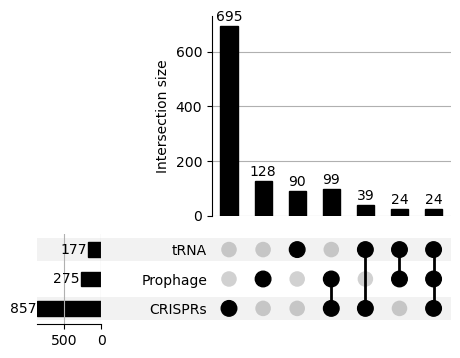

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from upsetplot import from_memberships
from upsetplot import plot


# Prepare data for UpSet plot
example = from_memberships(
    [
        ['CRISPRs'],
        ['Prophage'],
        ['tRNA'],
        ['CRISPRs', 'Prophage'],
        ['tRNA', 'CRISPRs'],
        ['tRNA', 'Prophage'],
        ['tRNA', 'CRISPRs', 'Prophage']
    ],
    data=[
        len(set(crispr_genus['qseqid']) - set(df_genus['qseqid']) - set(tRNA_genus['qseqid'])),
        len(set(df_genus['qseqid']) - set(crispr_genus['qseqid']) - set(tRNA_genus['qseqid'])),
        len(set(tRNA_genus['qseqid']) - set(df_genus['qseqid']) - set(crispr_genus['qseqid'])),
        len(set(crispr_genus['qseqid']) & set(df_genus['qseqid']) - set(tRNA_genus['qseqid'])),
        len(set(tRNA_genus['qseqid']) & set(crispr_genus['qseqid']) - set(df_genus['qseqid'])),
        len(set(tRNA_genus['qseqid']) & set(df_genus['qseqid']) - set(crispr_genus['qseqid'])),
        len(set(tRNA_genus['qseqid']) & set(crispr_genus['qseqid']) & set(df_genus['qseqid']))
    ]
)

# Plot the UpSet plot
plot(example, show_counts=True)

# Save the plot as a PDF
plt.savefig("upset_plot_genus_with_tRNA.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from upsetplot import from_memberships
from upsetplot import plot


# Prepare data for UpSet plot
example = from_memberships(
    [
        ['CRISPRs'],
        ['Prophage'],
        ['CRISPRs', 'Prophage']
    ],
    data=[
        len(set(crispr_genus['qseqid']) - set(df_genus['qseqid'])),
        len(set(df_genus['qseqid']) - set(crispr_genus['qseqid'])),
        len(set(crispr_genus['qseqid']) & set(df_genus['qseqid']))
    ]
)

# Plot the UpSet plot
plot(example, show_counts=True)

# Save the plot as a PDF
plt.savefig("upset_plot_genus.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

In [ ]:
crispr_family = crispr[crispr['cov'] >= 98]
crispr_family = crispr_family[crispr_family['pident'] >= 98]
crispr_family.drop_duplicates(subset=['qseqid'], inplace=True)
crispr_family = crispr_family[crispr_family['qfamily'] == crispr_family['sfamily']]
print("CRISPR", crispr_family.shape)

df_family = BLASTN_df[BLASTN_df['length'] >= 700]
df_family = df_family[df_family['pident'] >= 100]
df_family.drop_duplicates(subset=['qseqid'], inplace=True)
df_family = df_family[df_family['qfamily'] == df_family['sfamily']]
print("BLASTN", df_family.shape)

tRNA_family = tRNA[tRNA['cov'] >= 98]
tRNA_family = tRNA_family[tRNA_family['pident'] >= 98]
tRNA_family.drop_duplicates(subset=['qseqid'], inplace=True)
tRNA_family = tRNA_family[tRNA_family['sfamily'] == tRNA_family['sfamily']]
print("tRNA", tRNA_family.shape)

CRISPR (999, 15)
BLASTN (290, 10)
tRNA (244, 14)


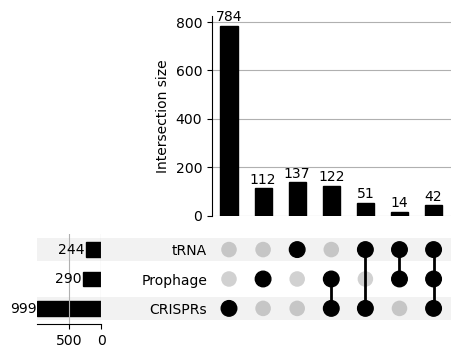

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from upsetplot import from_memberships
from upsetplot import plot


# Prepare data for UpSet plot
example = from_memberships(
    [
        ['CRISPRs'],
        ['Prophage'],
        ['tRNA'],
        ['CRISPRs', 'Prophage'],
        ['tRNA', 'CRISPRs'],
        ['tRNA', 'Prophage'],
        ['tRNA', 'CRISPRs', 'Prophage']
    ],
    data=[
        len(set(crispr_family['qseqid']) - set(df_family['qseqid']) - set(tRNA_family['qseqid'])),
        len(set(df_family['qseqid']) - set(crispr_family['qseqid']) - set(tRNA_family['qseqid'])),
        len(set(tRNA_family['qseqid']) - set(df_family['qseqid']) - set(crispr_family['qseqid'])),
        len(set(crispr_family['qseqid']) & set(df_family['qseqid']) - set(tRNA_family['qseqid'])),
        len(set(tRNA_family['qseqid']) & set(crispr_family['qseqid']) - set(df_family['qseqid'])),
        len(set(tRNA_family['qseqid']) & set(df_family['qseqid']) - set(crispr_family['qseqid'])),
        len(set(tRNA_family['qseqid']) & set(crispr_family['qseqid']) & set(df_family['qseqid']))
    ]
)

# Plot the UpSet plot
plot(example, show_counts=True)

# Save the plot as a PDF
plt.savefig("upset_plot_family_with_tRNA.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from upsetplot import from_memberships
from upsetplot import plot


# Prepare data for UpSet plot
example = from_memberships(
    [
        ['CRISPRs'],
        ['Prophage'],
        ['CRISPRs', 'Prophage']
    ],
    data=[
        len(set(crispr_family['qseqid']) - set(df_family['qseqid'])),
        len(set(df_family['qseqid']) - set(crispr_family['qseqid'])),
        len(set(crispr_family['qseqid']) & set(df_family['qseqid']))
    ]
)

# Plot the UpSet plot
plot(example, show_counts=True)

# Save the plot as a PDF
plt.savefig("upset_plot_family.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()